In [14]:
%run '0.0_init_configuration.ipynb'

# Support Vector Machines 

We will be using the wine quality data set for these exercises. This data set contains various chemical properties of wine, such as acidity, sugar, pH, and alcohol. It also contains a quality metric (3-9, with highest being better) and a color (red or white). The name of the file is Wine_Quality_Data.csv.

### Part 1: Setup
- Import the data.
- Create the target variable y as a 1/0 column where 1 means red.
- Create a pairplot for the dataset.
- Create a bar plot showing the correlations between each column and y
- Pick the most 2 correlated fields (using the absolute value of correlations) and create X
- Use MinMaxScaler to scale X. Note that this will output a np.array. Make it a DataFrame again and rename the columns appropriately.

In [15]:
df = pd.read_csv("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML241EN-SkillsNetwork/labs/datasets/Wine_Quality_Data.csv", sep=',')

In [16]:
# Convertimos de True o Falso a 1 y 0 binaria
y = (df['color'] == 'red').astype(int)

# set everything except "color"
fields = list(df.columns[:-1])

#calculamos la correlacion de pearson con la variable objetivo
correlations = df[fields].corrwith(y)
correlations.sort_values(inplace=True)
correlations

total_sulfur_dioxide   -0.700357
free_sulfur_dioxide    -0.471644
residual_sugar         -0.348821
citric_acid            -0.187397
quality                -0.119323
alcohol                -0.032970
pH                      0.329129
density                 0.390645
fixed_acidity           0.486740
sulphates               0.487218
chlorides               0.512678
volatile_acidity        0.653036
dtype: float64

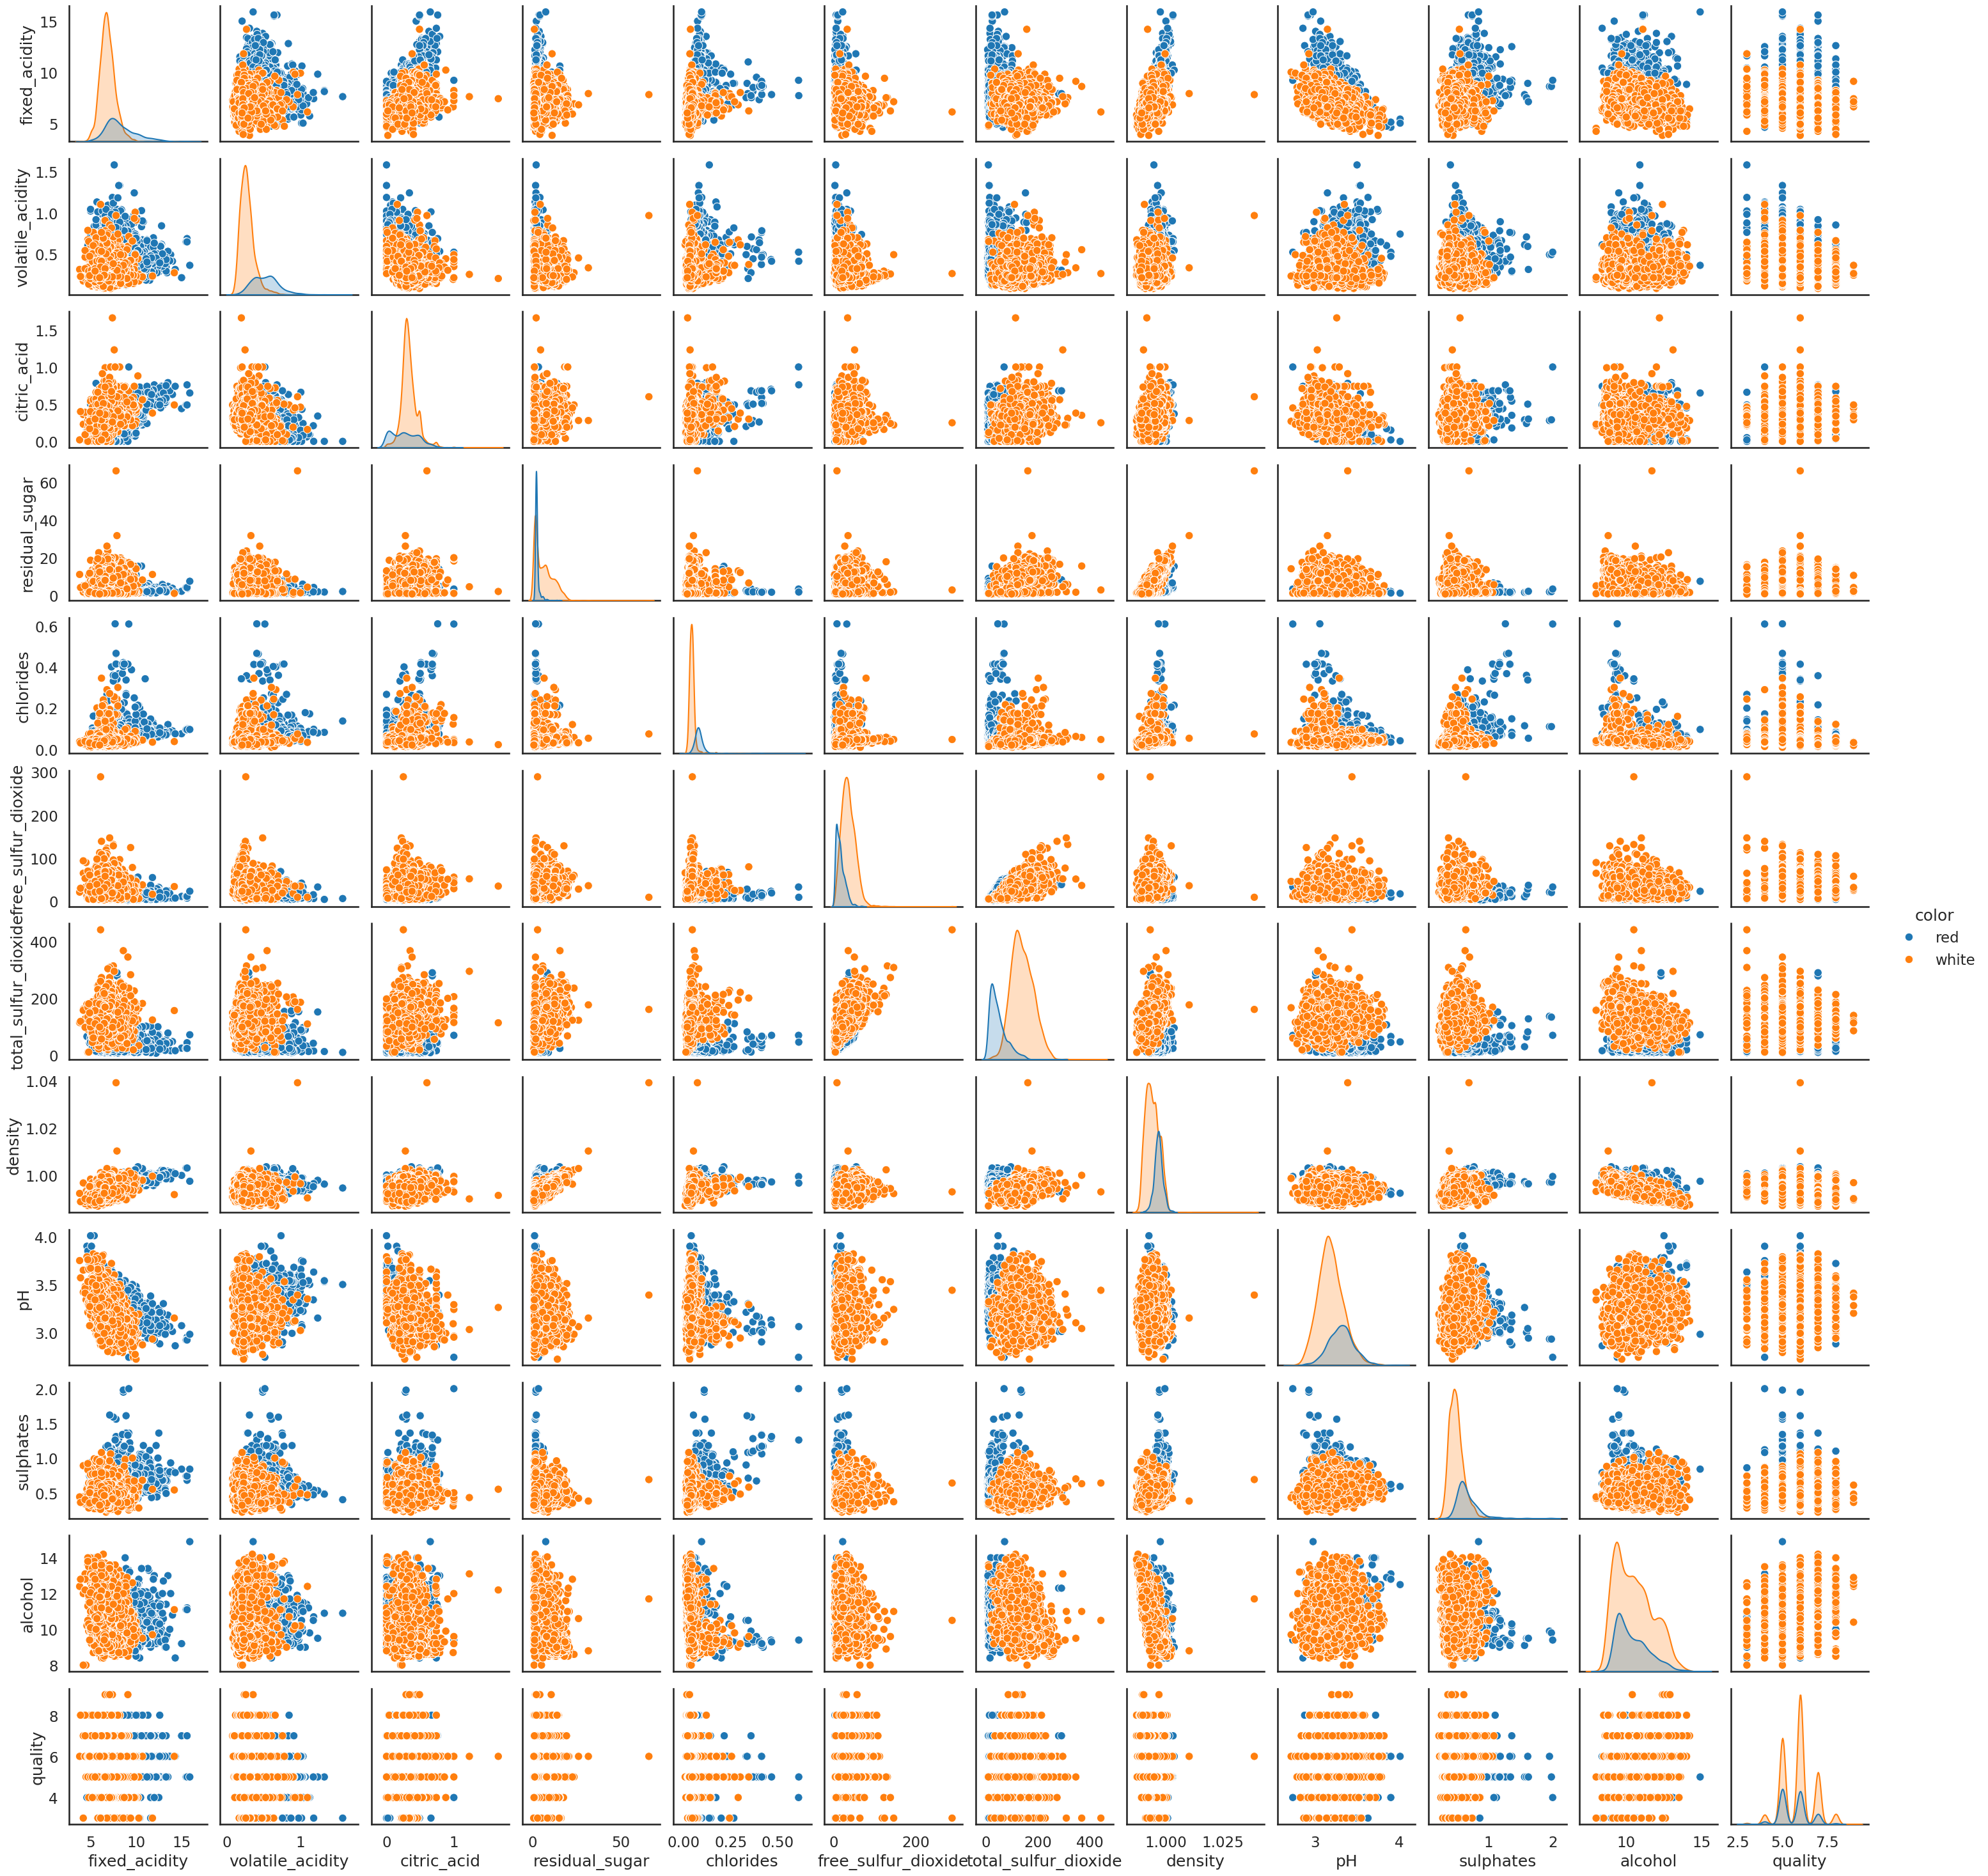

In [17]:
sns.set_context('talk')
sns.set_style('white')

sns.pairplot(df, hue='color')
plt.show()

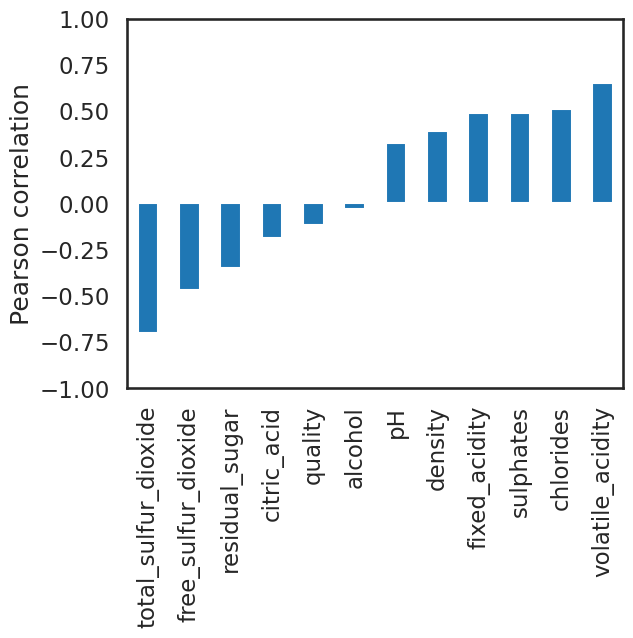

In [18]:
# Graficamos la correlacion de pearson
ax = correlations.plot(kind='bar')
ax.set(ylim=[-1,1], ylabel='Pearson correlation')
plt.show()

In [19]:
#usamos MinMaxScaler 
scaler = MinMaxScaler()

# Guardamos las variables con mas correlacion o relevantes
fields = correlations.map(abs).sort_values().iloc[-2:].index
fields

Index(['volatile_acidity', 'total_sulfur_dioxide'], dtype='object')

In [20]:
X = df[fields]
# Escalamos las variables entre 0 y 1 que es requisito importante para SVM
X = scaler.fit_transform(X)
X = pd.DataFrame(X, columns=['%s_scaled' % fld for fld in fields])
X

volatile_acidity_scaled  total_sulfur_dioxide_scaled
0                    0.413333                     0.064516
1                    0.533333                     0.140553
2                    0.453333                     0.110599
3                    0.133333                     0.124424
4                    0.413333                     0.064516
...                       ...                          ...
6492                 0.086667                     0.198157
6493                 0.160000                     0.373272
6494                 0.106667                     0.241935
6495                 0.140000                     0.239631
6496                 0.086667                     0.211982

[6497 rows x 2 columns]

### Part 2: Linear Decision Boundary
Our goal is to look at the decision boundary of a LinearSVC classifier on this dataset. Check out this example in sklearn's documentation.

- Fit a Linear Support Vector Machine Classifier to `X, y`.
- Pick 300 samples from `X`. Get the corresponding `y` value. Store them in variables `X_color` and `y_color`. This is because original dataset is too large and it produces a crowded plot.
- Modify `y_color` so that it has the value "red" instead of 1 and 'yellow' instead of 0.
- Scatter plot X_color's columns. Use the keyword argument "color=y_color" to color code samples.
- Use the code snippet below to plot the decision surface in a color coded way.

In [21]:
# Usamos LinearSVC method y ajustamos
LSVC = LinearSVC()
LSVC.fit(X,y)

# Escogemos una muestra de 300 ejemplos de X
X_color = X.sample(300, random_state=45)
# Seleccionamos las variable objetivo de acuerdo a la muestra random
y_color = y.loc[X_color.index]
y_color = y_color.map(lambda r: 'red' if r == 1 else 'yellow')

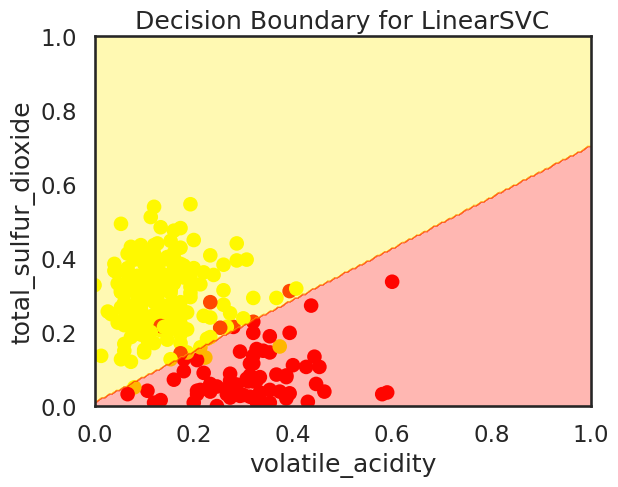

In [22]:
ax = plt.axes()
# Grafico de puntos
ax.scatter(X_color.iloc[:,0], # valores de la primera columna volatitle 
           X_color.iloc[:,1], # valores de la segunda columna sulfur
           color=y_color,
             alpha=1)

# -----------------
x_axis, y_axis = np.arange(0, 1.005, .005), np.arange(0, 1.005, .005)
xx, yy = np.meshgrid(x_axis, y_axis)
xx_ravel = xx.ravel()
yy_ravel = yy.ravel()

X_grid = pd.DataFrame([xx_ravel, yy_ravel]).T
y_grid_predictions = LSVC.predict(X_grid)
y_grid_predictions = y_grid_predictions.reshape(xx.shape)
ax.contourf(xx, yy, y_grid_predictions, cmap=plt.cm.autumn_r, alpha=.3)

#------------
ax.set(xlabel=fields[0],
       ylabel = fields[1],
       xlim=[0, 1],
       ylim=[0,1],
       title='Decision Boundary for LinearSVC')
plt.show()


### Part 3: Gaussian Kernel
Let's now fit a Gaussian kernel SVC and see how the decision boundary changes.

- Consolidate the code snippets in Question 2 into one function which takes in an estimator, `X` and `y`, and produces the final plot with decision boundary. The steps are:
1. Fit model
2. Get sample 300 records from X and the corresponding y's
3. Create grid, predict, plot using ax.contourf
4. Add on the scatter plot
- After copying and pasting code, the finished function uses the input estimator and not the LinearSVC model.
- For the following values of `gamma`, create a Gaussian Kernel SVC and plot the decision boundary.
`gammas = [.5, 1, 2, 10]`
- Holding `gamma` constant, we plot the decision boundary for various values of `C: [.1, 1, 10]`

In [23]:
def plot_decision_boundary(estimator, X, y):
    estimator.fit(X,y)
    X_color = X.sample(300)
    y_color = y.loc[X_color.index]
    y_color = y_color.map(lambda r: 'red' if r == 1 else 'yellow')
    x_axis, y_axis = np.arange(0, 1, .005), np.arange(0, 1, .005)
    xx, yy = np.meshgrid(x_axis, y_axis)
    xx_ravel = xx.ravel()
    yy_ravel = yy.ravel()
    X_grid = pd.DataFrame([xx_ravel, yy_ravel]).T
    y_grid_predictions = estimator.predict(X_grid)
    y_grid_predictions = y_grid_predictions.reshape(xx.shape)

    fig, ax = plt.subplots(figsize=(10, 10))
    ax.contourf(xx, yy, y_grid_predictions, cmap=plt.cm.autumn_r, alpha=.3)
    ax.scatter(X_color.iloc[:, 0], X_color.iloc[:, 1], color=y_color, alpha=1)
    ax.set(xlabel=fields[0],
            ylabel=fields[1],
            title=str(estimator))
    plt.show()

- Usa SVC si necesitas un clasificador con kernels no lineales o si sospechas que tus datos no son linealmente separables.
- Usa LinearSVC si sabes que tu problema es linealmente separable o si estás trabajando con un conjunto de datos grande, ya que es más eficiente y rápido para este tipo de problemas.

1. **Lineal (linear):** Se utiliza cuando los datos son aproximadamente separables de manera lineal.
2. **RBF (Radial Basis Function) (rbf):** Kernel no lineal, muy popular para datos complejos.
3. **Polinomial (poly):** Ajusta una frontera de decisión polinomial de grado d.
4. **Sigmoide (sigmoid):** Similar a una función de activación de redes neuronales, menos común en SVM.

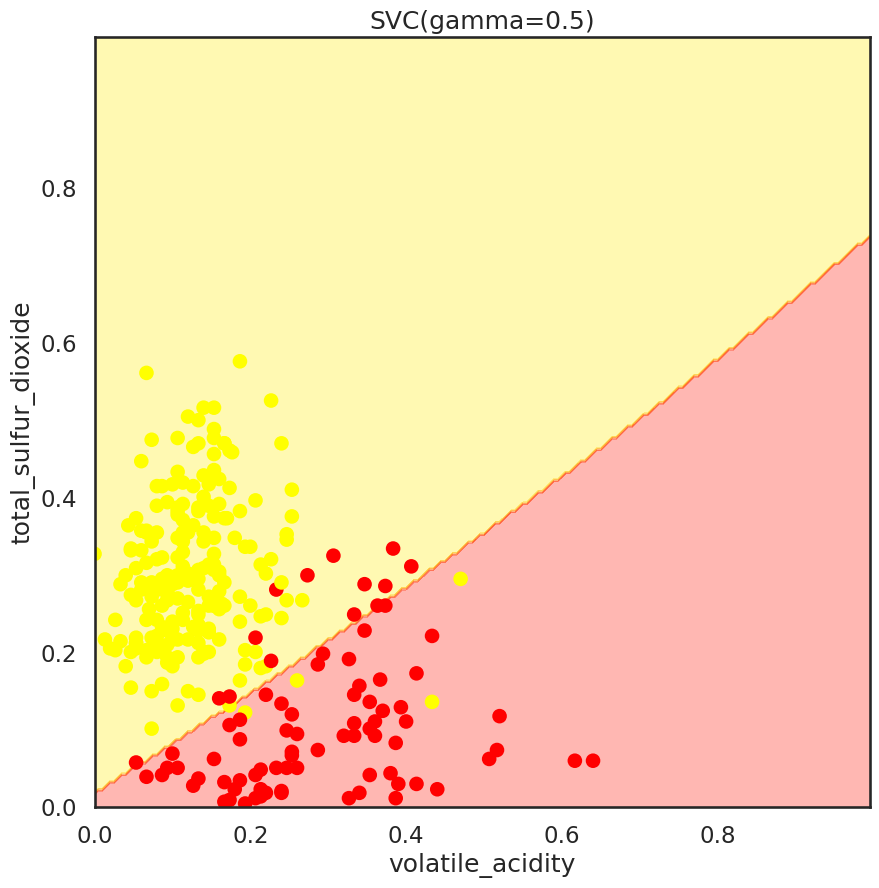

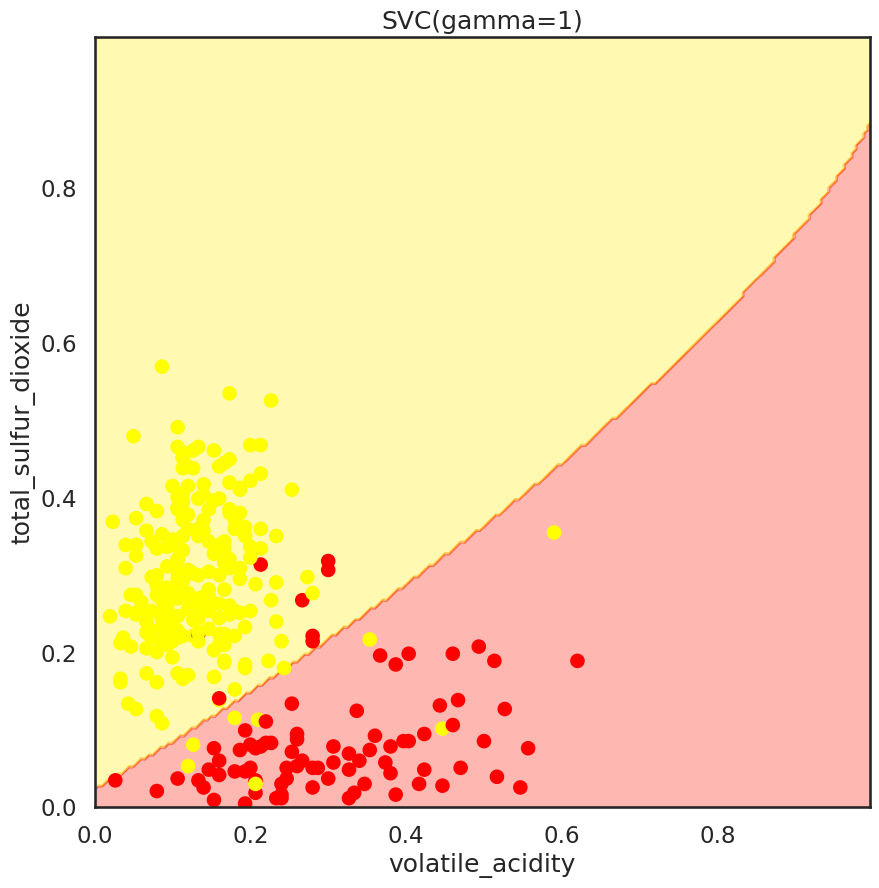

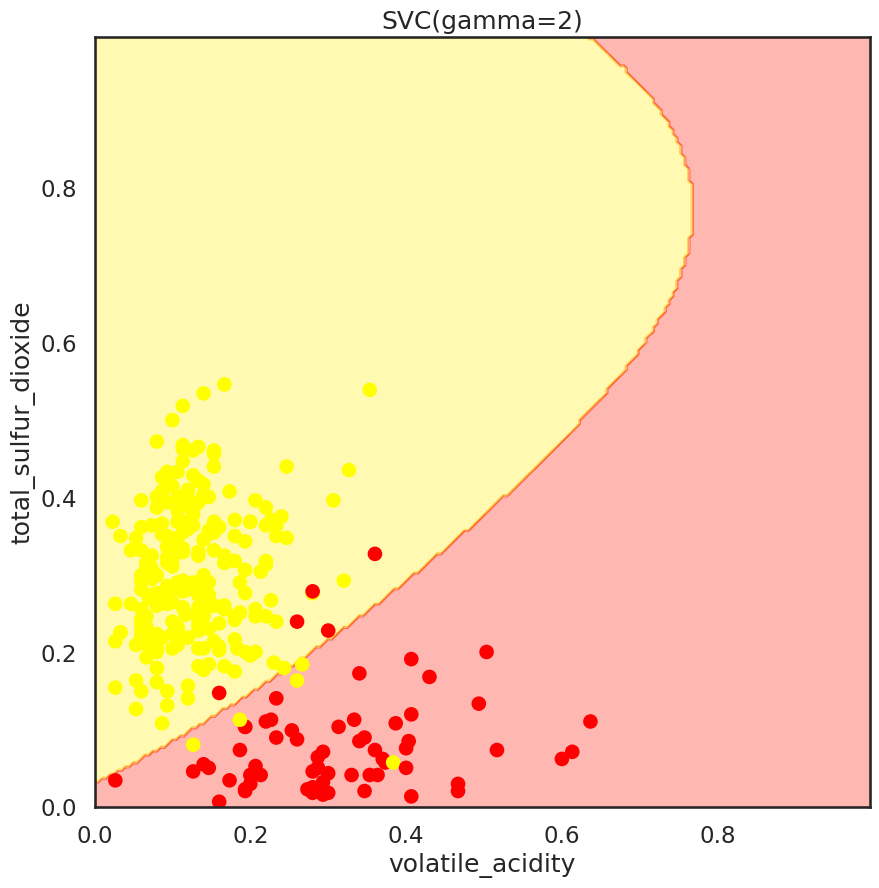

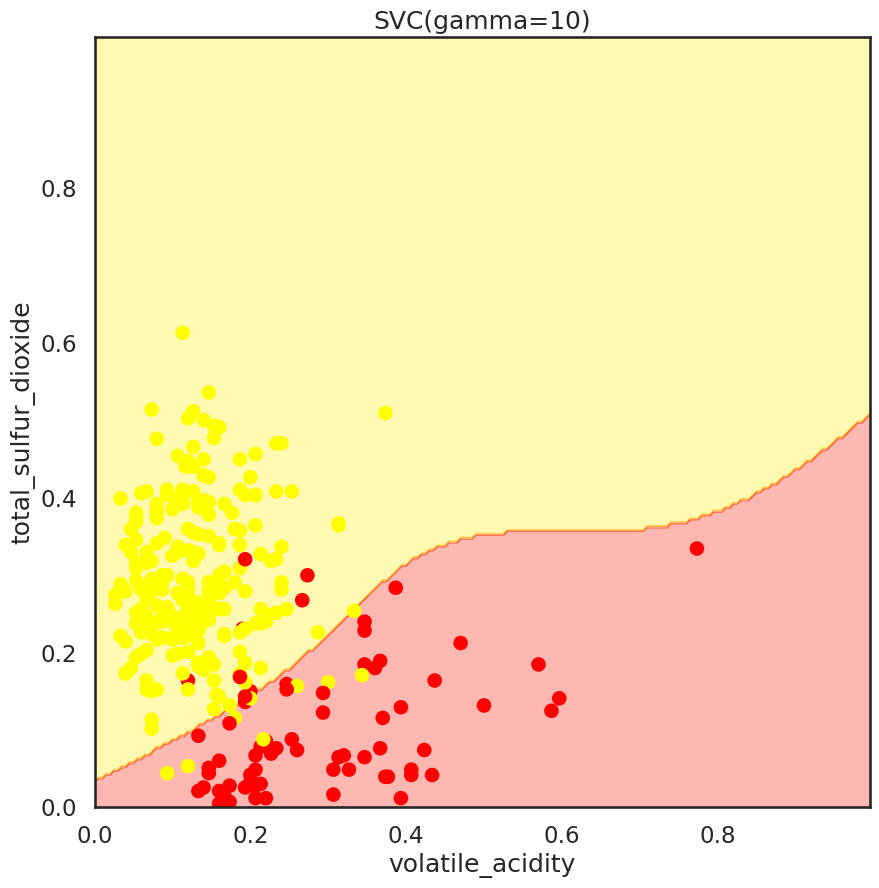

In [24]:
gammas = [.5, 1, 2, 10]

for gamma in gammas:
    SVC_Gaussian = SVC(kernel = 'rbf', gamma = gamma)
    plot_decision_boundary(SVC_Gaussian, X, y)

C ajusta la flexibilidad del modelo: un valor alto puede hacer que el modelo sea más rígido y propenso a sobreajustar, mientras que un valor bajo lo hace más permisivo y generalizable.



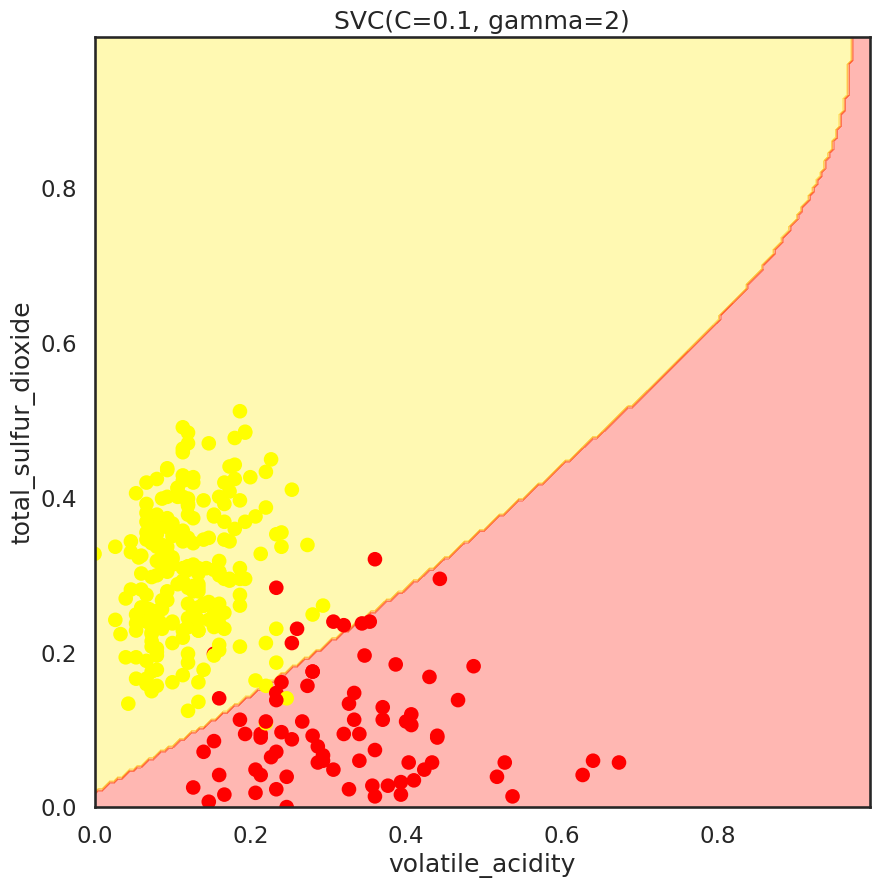

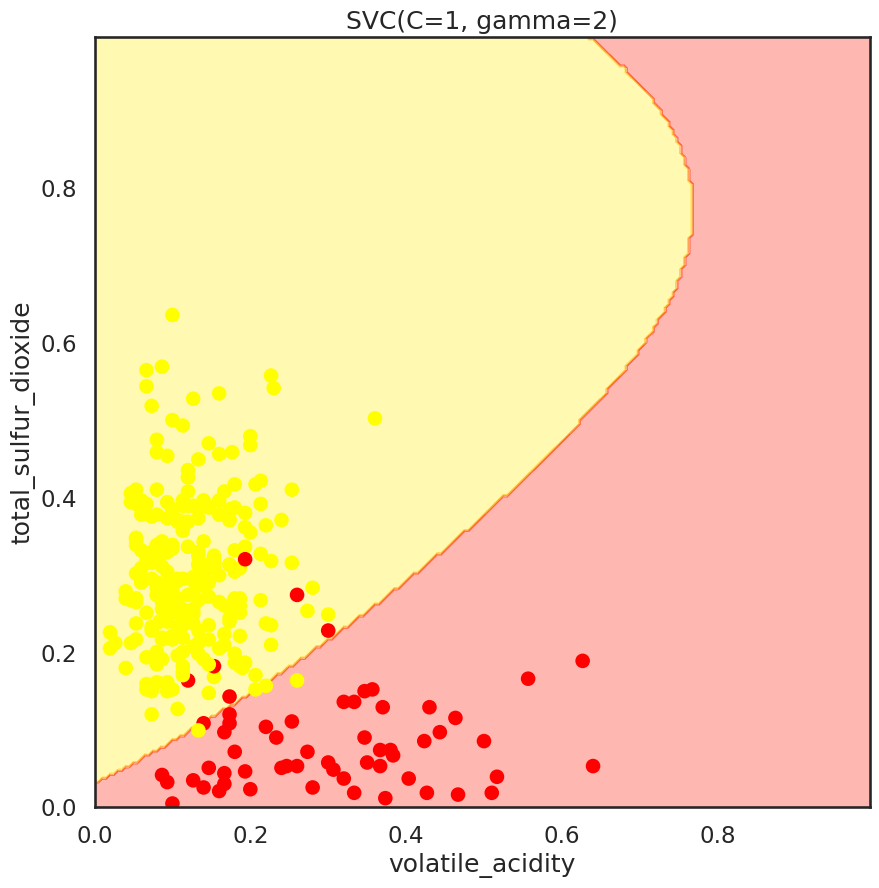

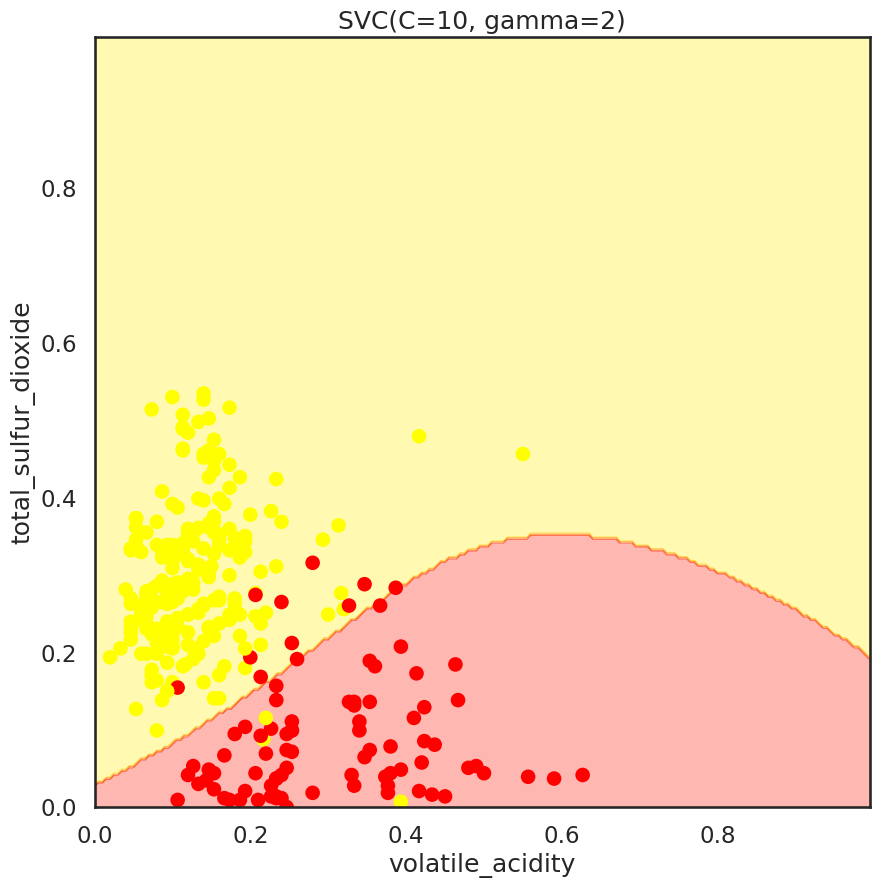

In [25]:
Cs = [.1, 1, 10]
for C in Cs:
    SVC_Gaussian = SVC(kernel = 'rbf', gamma  = 2, C = C)
    plot_decision_boundary(SVC_Gaussian, X, y)

### Part 4: Comparing Kernel Execution Times
In this exercise, we will compare the fitting times between SVC vs Nystroem with rbf kernel.

Jupyter Notebooks provide a useful magic function `%timeit` which executes a line and prints out the time it took to fit. If we type `%%timeit` in the beginning of the cell, it will output the execution time.

We proceed with the following steps:

- Create `y` from data.color, and `X` from the rest of the columns.
- Use `%%timeit` to get the time for fitting an SVC with rbf kernel.
- Use `%%timeit` to get the time for the following: fit_transform the data with Nystroem and then fit a SGDClassifier.

Nystroem+SGD will take much less to fit. This difference will be more pronounced if the dataset was bigger.

- Make 5 copies of X and concatenate them
- Make 5 copies of y and concatenate them
- Compare the time it takes to fit the both methods above

_La función Nystroem en scikit-learn se utiliza para aproximar el mapeo de un kernel de gran dimensión a un espacio de menor dimensión, permitiendo que los modelos que dependen de kernels (como el SVM) sean más eficientes en términos computacionales. Esta técnica es útil cuando se trabaja con conjuntos de datos grandes, ya que ayuda a reducir el costo de calcular el kernel completo._

In [ ]:
y = df.color == 'red'
X = df[df.columns[:-1]]


kwargs = {'kernel' : 'rbf'}
svc = SVC(**kwargs)

#Utilizamos Nystroem() method para hacer el kernel mas eficiente
nystroem = Nystroem(**kwargs)

#Utilizamos SGDClassifier para clasifación lineal con descenso de gradiente estocástico
sgd = SGDClassifier()

El objetivo es comprar tiempos de entrenamiento entre:
- Un SVM tradicional con kernel RBF
- Una aproximaciòn del Kernel (Nystroem) + un modelo lineal (SGFClassifier)

_La idea es que el segundo enfoque sea mucho más rápido, especialmente con datasets mas grandes._

In [27]:
%%timeit
svc.fit(X,y)

280 ms ± 14.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [30]:
%%timeit
X_transformed = nystroem.fit_transform(X)
sgd.fit(X_transformed, y)

243 ms ± 54.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [31]:
X2 = pd.concat([X]*5)
y2 = pd.concat([y]*5)

print(X2.shape)
print(y2.shape)

(32485, 12)
(32485,)


In [32]:
%timeit
svc.fit(X2, y2)

SVC()

In [33]:
%%timeit
X2_transformed = nystroem.fit_transform(X2)
sgd.fit(X2_transformed, y2)

468 ms ± 84.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
